In [1]:
import cv2
import glob
import numpy as np
from math import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

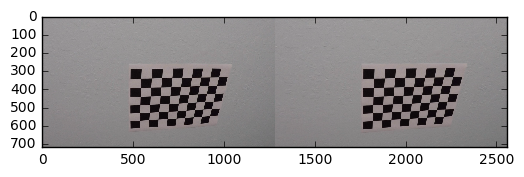

In [2]:
def calibrate_camera(images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    im = np.hstack((img, dst))
    plt.imshow(im)
    plt.show()
    
    return mtx, dist

cal_images = glob.glob('camera_cal/calibration*.jpg')
nx, ny = 9, 6
cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)

In [3]:
def sobel(gray, orient='x', sobel_kernel=3):
    return cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)

def abs_sobel_thresh(sobel, thresh=(0, 255)):
    # Calculate directional gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    retval, output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def mag_thresh(sobelx, sobely, thresh=(0, 255)):
    # Calculate gradient magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_sobel = (255*mag_sobel/np.max(mag_sobel)).astype(np.uint8)

    retval, output = cv2.threshold(mag_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def dir_threshold(sobelx, sobely, thresh=(0, np.pi/2)):
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = (np.absolute(np.arctan(sobely/sobelx)))
        dir_binary =  np.zeros_like(absgraddir, dtype=np.uint8)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    return dir_binary

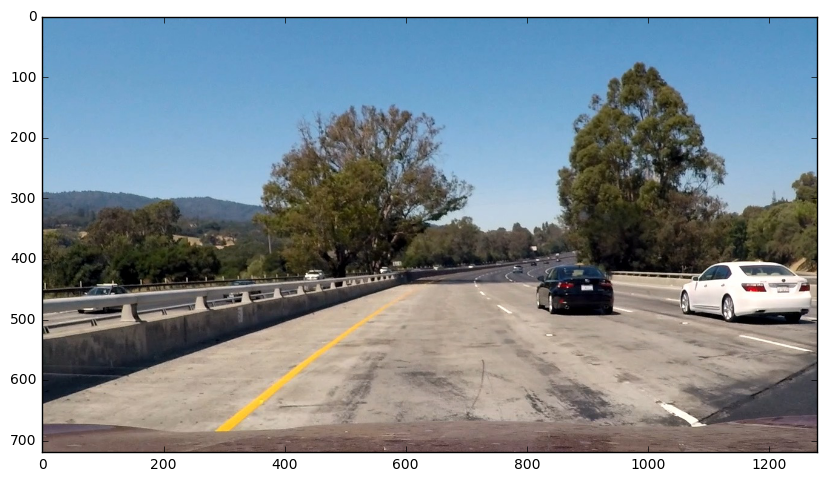

In [55]:
image = mpimage.imread('test_images/test1.jpg')
plt.imshow(image)
plt.show()

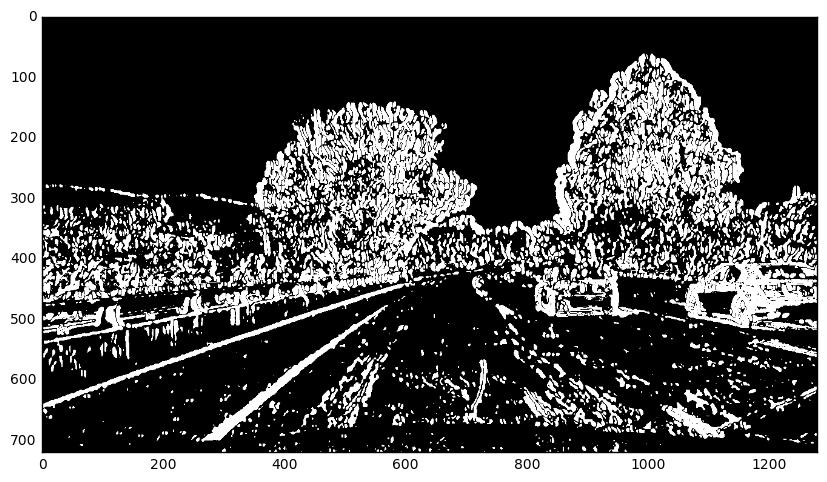

In [70]:
def find_edges(image, ksize = 15):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    sobelx = sobel(gray, orient='x', sobel_kernel=ksize)
    gradx = abs_sobel_thresh(sobelx, thresh=(10, 80))
    
    # sobely = sobel(gray, orient='y', sobel_kernel=ksize)
    # grady = abs_sobel_thresh(sobely, thresh=(90, 255))
    # mag_binary = mag_thresh(sobelx, sobely, thresh=(40, 100))
    # dir_binary = dir_threshold(sobelx, sobely, thresh=(0.7, 1.3))

    _, s_binary = cv2.threshold(s.astype('uint8'), 170, 255, cv2.THRESH_BINARY)

    color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary))
    combined_binary = np.clip(cv2.bitwise_or(s_binary, gradx), 0, 1).astype('uint8')
    return combined_binary

undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

edges = find_edges(undist)
plt.imshow(edges, cmap='gray')
plt.show()

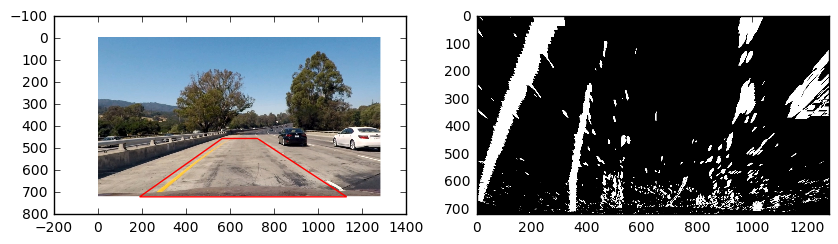

In [71]:
# Perspective transform
# 508, 567   # row x col 
# 508, 777

# 645, 383
# 645, 1019

def unwarp_image(img, mtx):
    return cv2.warpPerspective(img, mtx, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


img_size = image.shape
# src = np.array([[566., 455.],
#                 [789., 455.],
#                 [1020., 645.],
#                 [375., 645.]], np.float32)
src = np.array([[565., 455.],
                [725., 455.],
                [1130.,720.],
                [190., 720.]], np.float32)

dst = np.array([[300. , 0.  ],
                [1000., 0.  ],
                [1000., 720.],
                [300. , 720.]], np.float32)

warp_m = cv2.getPerspectiveTransform(src, dst)
warp_minv= cv2.getPerspectiveTransform(dst, src)

lanes = unwarp_image(edges, warp_m)

# plt.rcParams['figure.figsize'] = figsize=(10,12)

plt.figure(figsize=(10,12))
plt.subplot(1, 2, 1)
plt.imshow(undist)
plt.fill(src[:,0], src[:,1], edgecolor='r', fill=False)

plt.subplot(1, 2, 2)
plt.imshow(lanes, cmap='gray')

plt.show()

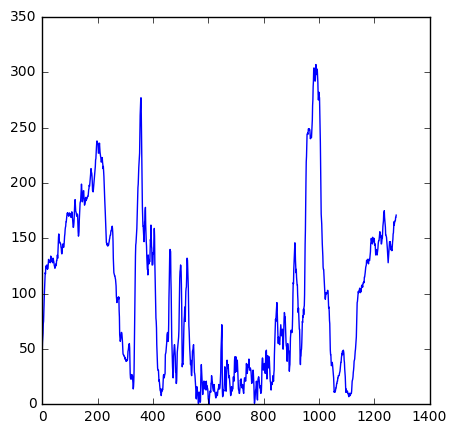

In [72]:
histogram = np.sum(lanes[:,:], axis=0)
plt.figure(figsize=(5,5))
plt.plot(histogram)